# Imports

In [2]:
%load_ext autoreload
%autoreload 2

%run ../../setup_project.py
%run ../../generic_plot_functions.py

import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Neuron import Simulated_grid_cell, Simulated_conjunctive_grid_cell, Simulated_HD_Cell
from spikeA.Animal_pose import Animal_pose
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import os
from spikeA.Neuron import Neuron
import datetime

from sim_grid_func import *
from neural_ds import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/dyrad_data_files
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


# Load data

In [ ]:
onlyOF = myProject.dataPath + "/results/jp451_lstm_firstRF.npy"
lastOF = myProject.dataPath + "/results/jp451_lstm_lastRF.npy"

seed_value = 42
np.random.seed(seed_value)

# Functions

In [5]:
def plotMap(
    ax,
    myMap,
    title="",
    titleY=0.95,
    titleFontSize=10,
    transpose=True,
    cmap="jet",
    vmin=0,
    alpha=1,
):
    """
    Plot one 2D map
    """
    if transpose:
        ax.imshow(
            myMap.T,
            origin="lower",
            cmap=cmap,
            interpolation=None,
            vmin=vmin,
            alpha=alpha,
        )
    else:
        ax.imshow(
            myMap, origin="lower", cmap=cmap, interpolation=None, vmin=vmin, alpha=alpha
        )
    ax.set_title(title, y=titleY, fontsize=titleFontSize)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

In [6]:
#Global Settings
global_bins = [-3.05432619, -2.87979327, -2.70526034, -2.53072742, -2.35619449,
       -2.18166156, -2.00712864, -1.83259571, -1.65806279, -1.48352986,
       -1.30899694, -1.13446401, -0.95993109, -0.78539816, -0.61086524,
       -0.43633231, -0.26179939, -0.08726646,  0.08726646,  0.26179939,
        0.43633231,  0.61086524,  0.78539816,  0.95993109,  1.13446401,
        1.30899694,  1.48352986,  1.65806279,  1.83259571,  2.00712864,
        2.18166156,  2.35619449,  2.53072742,  2.70526034,  2.87979327,
        3.05432619]

def plot_hd_map(ax,inputHistos):
    ax.plot(global_bins, inputHistos)
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(0,None)

# Setting up

In [5]:
grid_param = {}
grid_param["n_cells"] = 2
grid_param["orientation"] = np.array([0, np.pi / 3, np.pi / 3 * 2])
grid_spacing = 35
grid_param["period"] = np.array(
    [
        grid_spacing * np.cos(np.pi / 6),
        grid_spacing * np.cos(np.pi / 6),
        grid_spacing * np.cos(np.pi / 6),
    ]
)
grid_param["offset"] = (
    np.random.rand(grid_param["n_cells"], 2) * grid_param["period"][0]
)
# grid_param["offset"] = np.array([[12.97,32.93]])
peak_rates = np.random.normal(loc=15.0, scale=10.0, size=grid_param["n_cells"])
peak_rates[peak_rates < 5] = 5
grid_param["peak_rate"] = peak_rates
randomHd = np.random.randint(0, 361, size=grid_param["n_cells"])
grid_param['hd_dir'] = randomHd

# Simulate train set

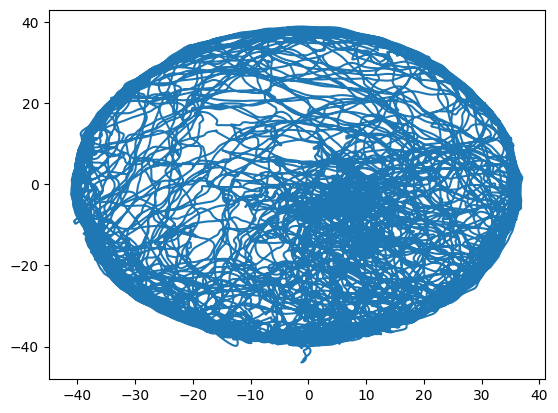

In [6]:
ap = Animal_pose()
ap.load_pose_from_file(file_name=onlyOF)


inter = ap.intervals.inter
ap.set_intervals(inter)


plt.plot(ap.pose[:, 1], ap.pose[:, 2])
plt.show()

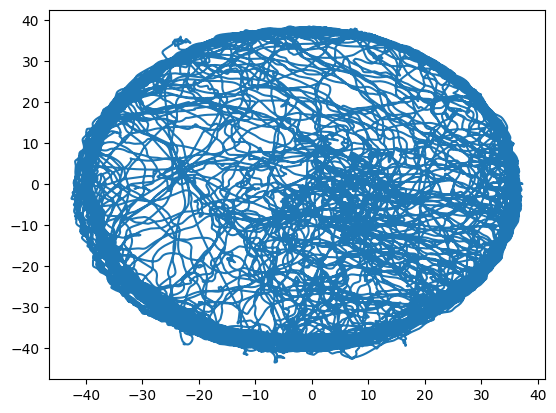

In [7]:
lap = Animal_pose()
lap.load_pose_from_file(file_name=lastOF)


plt.plot(lap.pose[:, 1], lap.pose[:, 2])
plt.show()

# Simulate 25 conjunctive cells

In [8]:
np.random.seed(0)

grid_param = {}
grid_param["n_cells"] = 25
grid_param["orientation"] = np.array([0,np.pi/3,np.pi/3*2])
grid_spacing = 35
grid_param["period"] = np.array([grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6)])
grid_param["offset"] = np.random.rand(grid_param["n_cells"],2)*grid_param["period"][0]
peak_rates = np.random.normal(loc=15.0, scale=10.0, size=grid_param["n_cells"] )
peak_rates[peak_rates<5] = 5
grid_param["peak_rate"] = peak_rates
randomHd = np.random.randint(0, 361, size=grid_param["n_cells"])
grid_param['hd_dir'] = randomHd

In [9]:
ap = Animal_pose()
ap.load_pose_from_file(file_name=onlyOF)

conjunctive_hd_neuron_list = [
    Simulated_conjunctive_grid_cell(
        name=f"{i}",
        offset=grid_param["offset"][i, :],
        orientation=grid_param["orientation"],
        period=grid_param["period"],
        peak_rate=grid_param["peak_rate"][i],
        ap=ap
        ,peakAngle=grid_param['hd_dir'][i],sharpness=5,peakRate=20,
        proportionOfGrid=0.02
    )
    for i in tqdm(range(grid_param["n_cells"]))
]

100%|██████████| 25/25 [01:12<00:00,  2.91s/it]


In [10]:
# Generate the test neuron list using simulated grid cells
# This neuron list uses position data from the second random foraging data
lap = Animal_pose()
lap.load_pose_from_file(file_name=lastOF)

test_conjunctive_hd_neuron_list = [
    Simulated_conjunctive_grid_cell(
        name=f"{i}",
        offset=grid_param["offset"][i, :],
        orientation=grid_param["orientation"],
        period=grid_param["period"],
        peak_rate=grid_param["peak_rate"][i],
        ap=lap
        ,peakAngle=grid_param['hd_dir'][i],
        sharpness=5,
        peakRate=20,
        proportionOfGrid=0.02
    )
    for i in tqdm(range(grid_param["n_cells"]))
    ]

100%|██████████| 25/25 [16:54<00:00, 40.59s/it] 


In [11]:
for n in conjunctive_hd_neuron_list:
    n.spatial_properties.firing_rate_map_2d()
    n.spatial_properties.firing_rate_head_direction_histogram(deg_per_bin=10, smoothing_sigma_deg=10,smoothing=True)  


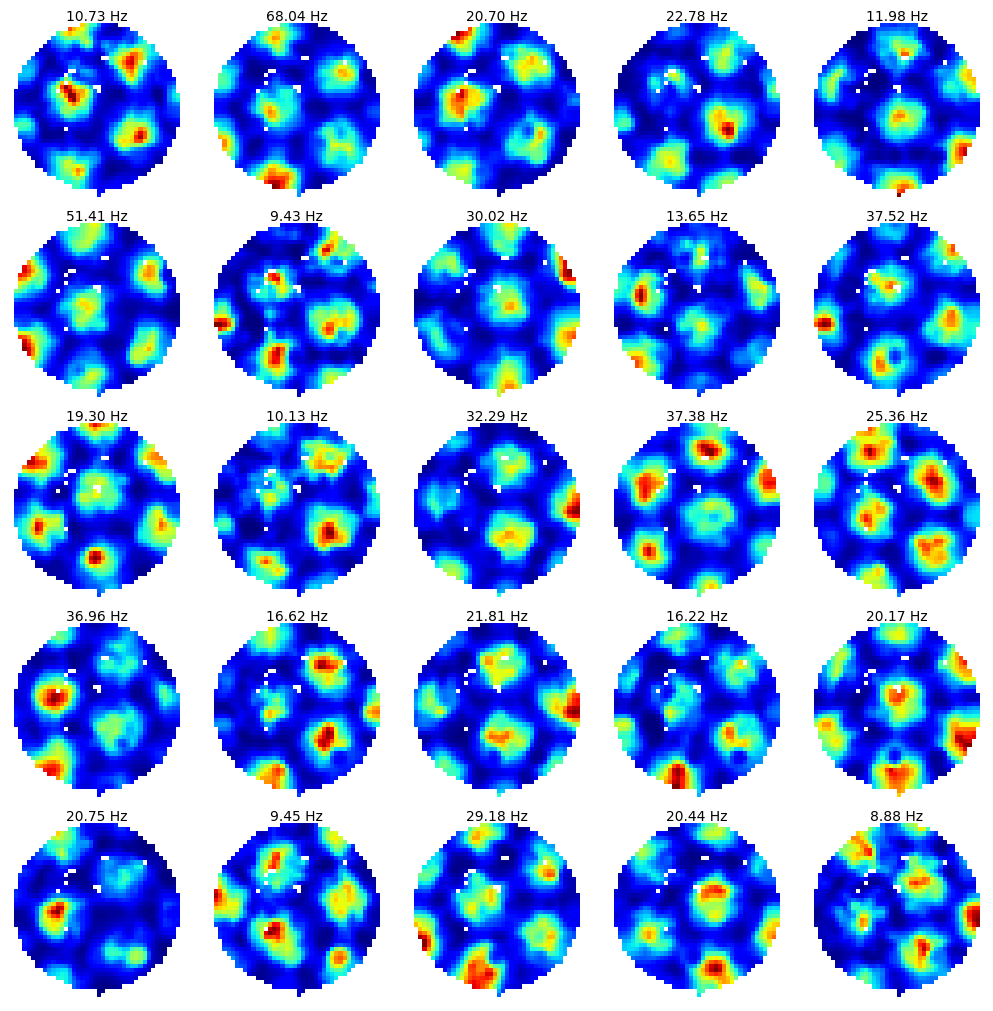

In [12]:
rowSize, colSize = 2, 2
ncols = 5
nrows = int(np.ceil(len(conjunctive_hd_neuron_list) / 5))
fig = plt.figure(
    figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True
)  # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(conjunctive_hd_neuron_list):
    x = int(i / ncols)
    y = i % ncols
    ax = fig.add_subplot(mainSpec[x, y])
    plotMap(
        ax,
        n.spatial_properties.firing_rate_map,
        title="{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)),
    )

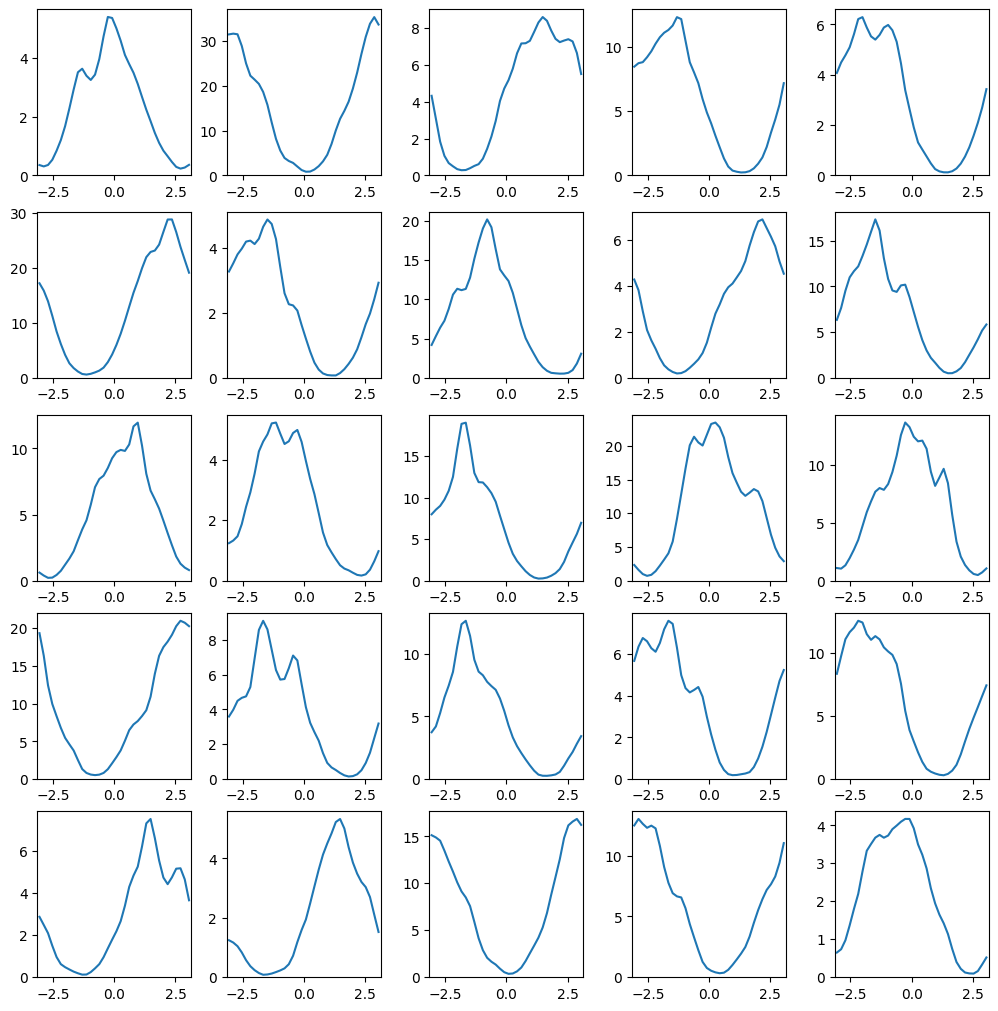

In [69]:
rowSize, colSize = 2, 2
ncols = 5
nrows = int(np.ceil(len(conjunctive_hd_neuron_list) / 5))
fig = plt.figure(
    figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True
)  # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(conjunctive_hd_neuron_list):
    x = int(i / ncols)
    y = i % ncols
    ax = fig.add_subplot(mainSpec[x, y])
    testNeuronHistos = n.spatial_properties.firing_rate_head_direction_histo
    plot_hd_map(ax,testNeuronHistos)

In [14]:
# Get the HD score of these simulated cells:
hdHolder = []
gridScoreHolder = []
for n in conjunctive_hd_neuron_list:
    hdscore = n.spatial_properties.head_direction_score()[2]
    gridscore = n.spatial_properties.grid_score()
    
    print(f"HD score: {hdscore}, grid score: {gridscore}")
    hdHolder.append(hdscore)
    gridScoreHolder.append(gridscore)
    
hdConDf = pd.DataFrame({'HD':hdHolder,'Grid':gridScoreHolder}) 

HD score: 0.4963280902411007, grid score: 1.5088038756478959
HD score: 0.5197071447559056, grid score: 1.5611428072273226
HD score: 0.47414867142825257, grid score: 1.401367885353693
HD score: 0.5051305501453692, grid score: 1.2182376489266211
HD score: 0.5107865946779051, grid score: 1.451727058237232
HD score: 0.5292371873953537, grid score: 1.496804337710865
HD score: 0.5135381983803584, grid score: 1.330224400737363
HD score: 0.5285194908997533, grid score: 1.5794401486607939
HD score: 0.5011825911833587, grid score: 1.462148926641941
HD score: 0.48395035186987545, grid score: 1.5830286743915862
HD score: 0.5191376553720254, grid score: 1.5425667615737204
HD score: 0.5157733819060892, grid score: 1.3766661022831328
HD score: 0.5391503663624115, grid score: 1.2900200389964198
HD score: 0.45483010757589043, grid score: 1.574057109888102
HD score: 0.4678575021785721, grid score: 1.465273768762545
HD score: 0.5293814983858677, grid score: 1.4134230141875004
HD score: 0.4961713934339916

In [15]:
hdConDf['cellType'] = 'conjunctive'

# Simulate 25 grid cells

In [16]:
conjunctive_grid_neuron_list = [
    Simulated_conjunctive_grid_cell(
        name=f"{i}",
        offset=grid_param["offset"][i, :],
        orientation=grid_param["orientation"],
        period=grid_param["period"],
        peak_rate=grid_param["peak_rate"][i],
        ap=ap
        ,peakAngle=grid_param['hd_dir'][i],sharpness=1,peakRate=20,
        proportionOfGrid=0.6
    )
    for i in tqdm(range(grid_param["n_cells"]))
]

100%|██████████| 25/25 [01:11<00:00,  2.86s/it]


In [17]:
test_conjunctive_grid_neuron_list = [
    Simulated_conjunctive_grid_cell(
        name=f"{i}",
        offset=grid_param["offset"][i, :],
        orientation=grid_param["orientation"],
        period=grid_param["period"],
        peak_rate=grid_param["peak_rate"][i],
        ap=lap
        ,peakAngle=grid_param['hd_dir'][i],sharpness=1,peakRate=20,
        proportionOfGrid=0.6
    )
    for i in tqdm(range(grid_param["n_cells"]))
]

100%|██████████| 25/25 [01:09<00:00,  2.76s/it]


In [18]:
for n in conjunctive_grid_neuron_list:
    n.spatial_properties.firing_rate_map_2d()
    n.spatial_properties.firing_rate_head_direction_histogram(deg_per_bin=10, smoothing_sigma_deg=10,smoothing=True)  


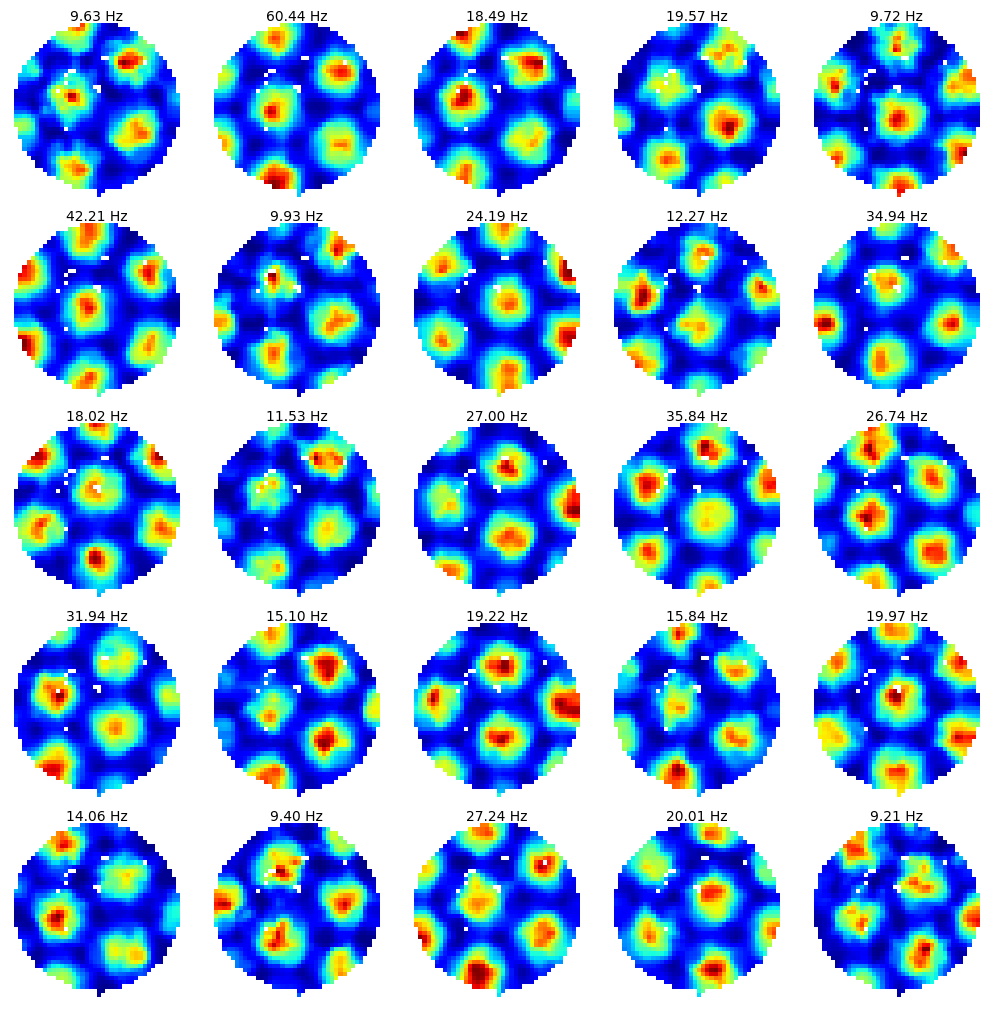

In [66]:
rowSize, colSize = 2, 2
ncols = 5
nrows = int(np.ceil(len(conjunctive_grid_neuron_list) / 5))
fig = plt.figure(
    figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True
)  # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(conjunctive_grid_neuron_list):
    x = int(i / ncols)
    y = i % ncols
    ax = fig.add_subplot(mainSpec[x, y])
    plotMap(
        ax,
        n.spatial_properties.firing_rate_map,
        title="{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)),
    )

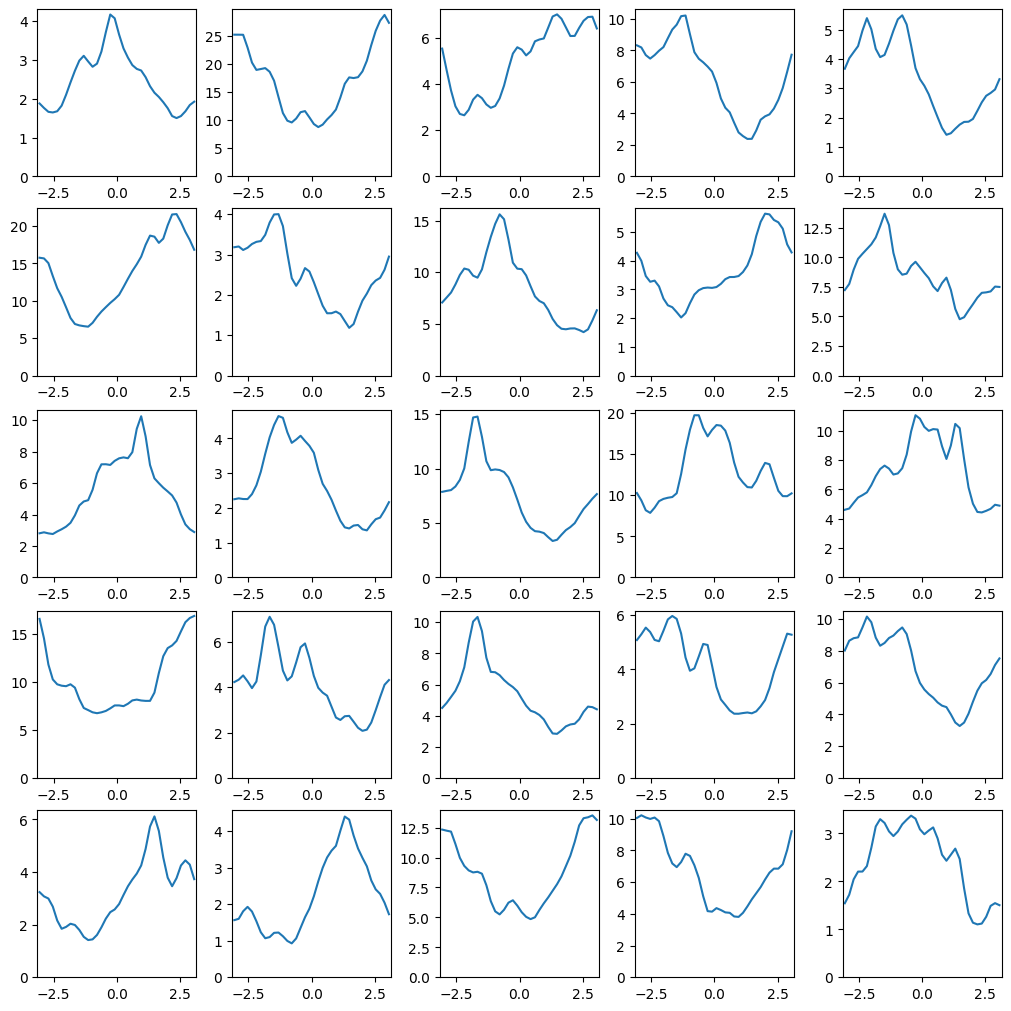

In [70]:
rowSize, colSize = 2, 2
ncols = 5
nrows = int(np.ceil(len(conjunctive_grid_neuron_list) / 5))
fig = plt.figure(
    figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True
)  # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(conjunctive_grid_neuron_list):
    x = int(i / ncols)
    y = i % ncols
    ax = fig.add_subplot(mainSpec[x, y])
    testNeuronHistos = n.spatial_properties.firing_rate_head_direction_histo
    plot_hd_map(ax,testNeuronHistos)

In [21]:
# Get the HD score of these simulated cells:
hdHolder = []
gridScoreHolder = []
for n in conjunctive_grid_neuron_list:
    hdscore = n.spatial_properties.head_direction_score()[2]
    gridscore = n.spatial_properties.grid_score()
    
    print(f"HD score: {hdscore}, grid score: {gridscore}")
    hdHolder.append(hdscore)
    gridScoreHolder.append(gridscore)
    
hdGridDf = pd.DataFrame({'HD':hdHolder,'Grid':gridScoreHolder}) 

HD score: 0.20015100379888048, grid score: 1.5008313579852555
HD score: 0.24566080782761862, grid score: 1.5839139414645307
HD score: 0.19313495980097328, grid score: 1.4495701673866057
HD score: 0.2587860097317894, grid score: 1.4171827755477642
HD score: 0.253168157344181, grid score: 1.6030070418481408
HD score: 0.2462551489542476, grid score: 1.5347014668076486
HD score: 0.21410277909500483, grid score: 1.4167136654332295
HD score: 0.2569526680624403, grid score: 1.5512913579963872
HD score: 0.18578544579518663, grid score: 1.581615490232189
HD score: 0.15791136338846576, grid score: 1.5718832344219273
HD score: 0.2637999529288514, grid score: 1.5463522165353334
HD score: 0.26590435874401025, grid score: 1.4473351969105983
HD score: 0.2725352081867114, grid score: 1.4109310960508934
HD score: 0.16625007750249468, grid score: 1.5871910819458148
HD score: 0.18990849489616263, grid score: 1.526970757615242
HD score: 0.2061829082065369, grid score: 1.5333323704881807
HD score: 0.201371

In [22]:
hdGridDf['cellType'] = 'grid'

In [23]:
allTogether = pd.concat([hdConDf,hdGridDf])

Mann-Whitney U test: MannwhitneyuResult(statistic=412.0, pvalue=0.05474656657484588)


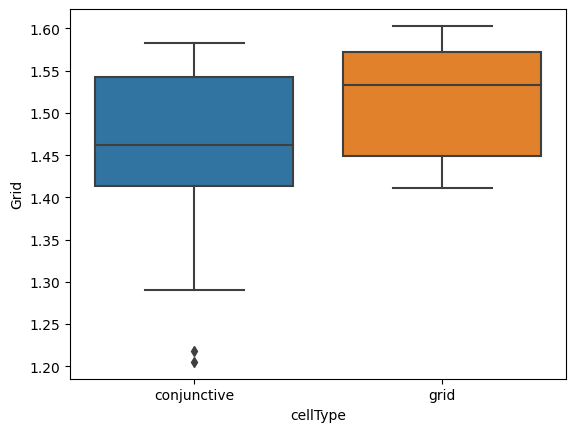

In [24]:
import scipy.stats as stats

fig, ax =plt.subplots()

b = sns.boxplot(data=allTogether,x='cellType',y='Grid', ax = ax)
#ax.set_ylim(0,1)

# Define the groups
group1 = allTogether[allTogether['cellType'] == 'grid']['Grid']
group2 = allTogether[allTogether['cellType'] == 'conjunctive']['Grid']

# Perform the t-test
outStats = stats.mannwhitneyu(group1, group2)

# Print the results
print(f"Mann-Whitney U test: {outStats}")


Mann-Whitney U test: MannwhitneyuResult(statistic=0.0, pvalue=1.4156562248495541e-09)


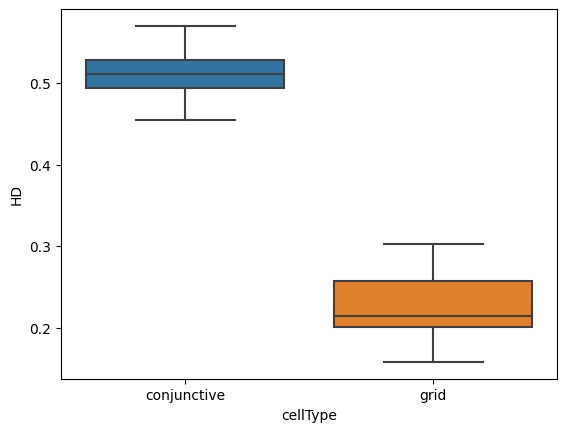

In [25]:
import scipy.stats as stats

fig, ax =plt.subplots()

b = sns.boxplot(data=allTogether,x='cellType',y='HD', ax = ax)
#ax.set_ylim(0,1)

# Define the groups
group1 = allTogether[allTogether['cellType'] == 'grid']['HD']
group2 = allTogether[allTogether['cellType'] == 'conjunctive']['HD']

# Perform the t-test
outStats = stats.mannwhitneyu(group1, group2)

# Print the results
print(f"Mann-Whitney U test: {outStats}")


# Prepare the data for model input

In [ ]:
def generate_data_from_neuron_list(inputNeuronList,animalPose):
    outputPose = np.stack(
    [animalPose.pose[:, 0], animalPose.pose[:, 1], animalPose.pose[:, 2]]).T  # only consider the data that we will be using
    #Loop for firing rate map
    for n in inputNeuronList:
        n.spatial_properties.firing_rate_map_2d()
        
    ifrList = []
    stList = []
    for i, n in tqdm(enumerate(inputNeuronList)):
        n.spike_train.instantaneous_firing_rate(
            bin_size_sec=0.02, sigma=2, shift_start_time=0.02
        )
        ifrList.append(n.spike_train.ifr[0])
        stList.append(n.spike_train.st)
        if i == 0:
            time = n.spike_train.ifr[2]
        n.spike_train.ifr = None  # remove the reference to the numpy array, which can be deleted by garbage collector

    ifr, time = (
        np.stack(ifrList, axis=0),
        time.round(4),
    )  # added the round so that the numbers are not 0.019999999 but 0.02

    output_ifr = ifr.T
    output_time = time
    
    print(f"Ifr shape: {output_ifr.shape}")
    print(f"Time shape: {output_time.shape}")
    print(f"Pose shape: {outputPose.shape}")
    
    assert output_ifr.shape[0] == outputPose.shape[0]
    
    return output_ifr, output_time, outputPose

In [27]:
# Generate the training data for conjunctive cells
con_ifr, con_time, con_pose = generate_data_from_neuron_list(conjunctive_hd_neuron_list,ap)

25it [00:00, 114.47it/s]

Ifr shape: (87406, 25)
Time shape: (87406,)
Pose shape: (87406, 3)


In [28]:
# Generate the test data for conjunctive cells
con_ifr_test, con_time_test, con_pose_test = generate_data_from_neuron_list(test_conjunctive_hd_neuron_list,lap)

25it [00:00, 113.99it/s]

Ifr shape: (87750, 25)
Time shape: (87750,)
Pose shape: (87750, 3)


In [29]:
# Generate the training data for grid cells
gri_ifr, gri_time, gri_pose = generate_data_from_neuron_list(conjunctive_grid_neuron_list,ap)

25it [00:00, 113.61it/s]

Ifr shape: (87406, 25)
Time shape: (87406,)
Pose shape: (87406, 3)


In [30]:
# Generate the test data for grid cells
gri_ifr_test, gri_time_test, gri_pose_test = generate_data_from_neuron_list(test_conjunctive_grid_neuron_list,lap)

25it [00:00, 112.79it/s]

Ifr shape: (87750, 25)
Time shape: (87750,)
Pose shape: (87750, 3)


In [ ]:
# Save the firing rate files
ROOT_FN = myProject.dataPath + '/results/hd_grid_simulation/'

fn = ROOT_FN + "train_ifr_conjunctive.pkl"
pickle.dump((con_ifr,con_time),open(fn,"wb"))

fn = ROOT_FN + "test_ifr_conjunctive.pkl"
pickle.dump((con_ifr_test,con_time_test),open(fn,"wb"))

fn = ROOT_FN + "train_ifr_grid.pkl"
pickle.dump((gri_ifr,gri_time),open(fn,"wb"))

fn = ROOT_FN + "test_ifr_grid.pkl"
pickle.dump((gri_ifr_test,gri_time_test),open(fn,"wb"))

print('Ifr, time saved')

Ifr, time saved


In [32]:
# Save the animal pose files

assert np.all(con_pose == gri_pose)
assert np.all(con_pose_test == gri_pose_test)

fn = ROOT_FN + "train_pose.pkl"
pickle.dump(con_pose,open(fn,"wb"))

fn = ROOT_FN + "test_pose.pkl"
pickle.dump(gri_pose_test,open(fn,"wb"))

print('Pose saved')

Pose saved


In [33]:
# Save grid params
fn = ROOT_FN + "grid_params.pkl"
pickle.dump(grid_param,open(fn,"wb"))

print('Saved grid params to:',fn)

Saved grid params to: ../../data/hd_grid_simulation/grid_params.pkl


# Test two groups using model

In [34]:
def load_position_ifr_dataset_conjunctive_simulation(dirPath=ROOT_FN,cellType='conjunctive'):
    # NOTE First load the train and test pose, theses are the same for all cells
    
    fn = os.path.join(dirPath,"train_pose.pkl")
    train_pose = pickle.load(open(fn,"rb"))
    
    fn = os.path.join(dirPath,"test_pose.pkl")
    test_pose = pickle.load(open(fn,"rb"))
    
    if cellType == 'conjunctive':
        fn = os.path.join(dirPath,"train_ifr_conjunctive.pkl")
        ifrTime = pickle.load(open(fn,"rb"))
        train_ifr, train_time = ifrTime

        fn = os.path.join(dirPath,"test_ifr_conjunctive.pkl")
        ifrTime = pickle.load(open(fn,"rb"))
        test_ifr, test_time = ifrTime
        
    elif cellType == 'grid':
        fn = os.path.join(dirPath,"train_ifr_grid.pkl")
        ifrTime = pickle.load(open(fn,"rb"))
        train_ifr, train_time = ifrTime

        fn = os.path.join(dirPath,"test_ifr_grid.pkl")
        ifrTime = pickle.load(open(fn,"rb"))
        test_ifr, test_time = ifrTime
    
    # NOTE Load the grid params    
    fn = os.path.join(dirPath,"grid_params.pkl")
    grid_param = pickle.load(open(fn,"rb"))
    print("train_ifr.shape:",train_ifr.shape)
    print("train_pose.shape:",train_pose.shape)

    # The following is needed if you use an extracted grid param from the model
    # oriRigid = np.stack([p["grid_param_model_rigid"]["orientation"] for p in grid_param])
    # oriFlexible = np.stack([p["grid_param_model_flexible"]["orientation"] for p in grid_param])
    # periodRigid = np.stack([p["grid_param_model_rigid"]["period"] for p in grid_param])
    # periodFlexible = np.stack([p["grid_param_model_flexible"]["period"] for p in grid_param])


    # grid_param = {
    # "period": np.median(periodFlexible,axis=0),
    # "orientation": np.median(oriFlexible,axis=0),
    # }
    
    
    if train_ifr.shape[0] != train_pose.shape[0]:
        raise ValueError("Problem with the shape of ifr and pose object")
    if test_ifr.shape[0] != test_pose.shape[0]:
        raise ValueError("Problem with the shape of ifr and pose object")
        
    train_grid_coord = poseToGridSpace(pose=train_pose[:,1:3],
                             period=grid_param["period"],
                             orientation=grid_param["orientation"])
    
    
    test_grid_coord = poseToGridSpace(pose=test_pose[:,1:3],
                             period=grid_param["period"],
                             orientation=grid_param["orientation"])
    
    return train_ifr, train_pose, train_grid_coord, test_ifr, test_pose, test_grid_coord, grid_param, train_time, test_time


In [35]:
def lossOnTestDataset(model,test_data_loader,device,loss_fn):
    model.eval()
    loss_test = 0
    with torch.no_grad():
        for imgs, labels, time in test_data_loader: 
            imgs = imgs.to(device=device) 
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)
            loss_test += loss.item()
    a = model.train()
    return loss_test/len(test_data_loader)

In [36]:
def training_loop(n_epochs,
                 optimizer,
                 model,
                 loss_fn,
                 train_data_loader,
                 test_data_loader,
                 config,
                  device,
                 verbose=False,best_loss=float('inf'),
                 best_model_state=None):
    
    if verbose:
        print("Training starting at {}".format(datetime.datetime.now()))
    testLoss =  lossOnTestDataset(model,test_data_loader,device,loss_fn)
    trainLoss = lossOnTestDataset(model,train_data_loader,device,loss_fn)
    if verbose:
        print("Test loss without training: {}".format(testLoss))
    
    df = pd.DataFrame({"epochs": [0],
                       "seq_length": config["seq_length"],
                       "n_cells": config["n_cells"],
                       "hidden_size": config["hidden_size"],
                       "num_layers": config["num_layers"],
                      "learning_rate": config["learning_rate"],
                      "batch_size": config["batch_size"],
                      "train_loss": trainLoss,
                      "test_loss": testLoss})

    for epoch in range(1,n_epochs+1):
        loss_train = 0
        for imgs, labels, time in train_data_loader: 
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
        testLoss = lossOnTestDataset(model,test_data_loader,device,loss_fn)
        if verbose:
            print("{} Epoch: {}/{}, Training loss: {}, Testing loss: {}".format(datetime.datetime.now(),epoch,n_epochs,loss_train/len(train_data_loader), testLoss))
        df1 = pd.DataFrame({"epochs": [epoch],
                       "seq_length": config["seq_length"],
                       "n_cells": config["n_cells"],
                       "hidden_size": config["hidden_size"],
                       "num_layers": config["num_layers"],
                      "learning_rate": config["learning_rate"],
                      "batch_size": config["batch_size"],
                      "train_loss": loss_train/len(train_data_loader),
                           "test_loss": testLoss})
        
        df = pd.concat([df, df1])

        if testLoss < best_loss:
            best_loss = testLoss
            best_model_state = model.state_dict()

    return df, best_model_state


In [ ]:
def train_lstm(config,train_grid_coord, train_time, train_ifr, test_grid_coord, test_time,test_ifr, verbose=True):
    """
    This only takes the first 4 columns in train_grid_coord and test_grid_coord (v0, v1)
    """
    
    print(datetime.datetime.now(),config)
    
    train_dataset = NeuralDatasetSimple(ifr =train_ifr[:,:config["n_cells"]], pose=train_grid_coord[:,0:4], time=train_time,  seq_length=config["seq_length"])
    ifr_normalization_means = train_dataset.ifr_normalization_means
    ifr_normalization_stds = train_dataset.ifr_normalization_stds
    
    myDict = {"ifr_normalization_means": ifr_normalization_means,
              "ifr_normalization_stds": ifr_normalization_stds}
    # Save the normalization means and stds during the first run, you can then loaded it later
    # fn = sSes.fileBase+".rnn_ifr_normalization.pkl"
    # print("Saving:",fn)
    # with open(fn, 'wb') as handle:
    #     pickle.dump(myDict, handle)
    
    
    test_dataset = NeuralDatasetSimple(ifr =test_ifr[:,:config["n_cells"]], 
                             pose=test_grid_coord[:,0:4], 
                                 time= test_time,
                             seq_length=config["seq_length"],
                             ifr_normalization_means=ifr_normalization_means,
                             ifr_normalization_stds=ifr_normalization_stds)
    
    
    
    
    train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=config["batch_size"] , num_workers=2, shuffle=True, pin_memory=True) # to load batches
    test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=config["batch_size"] , num_workers=2, shuffle=False, pin_memory=False) # to load batches

    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('mps'))
    model = LSTMSimple(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)

    


    
    optimizer = torch.optim.SGD(model.parameters(),lr=config["learning_rate"])
    loss_fn = torch.nn.MSELoss() # 

    model.train()

    best_loss = float('inf')  # Initialize with a large value
    best_model_state = None

    df,best_model_state = training_loop(n_epochs=config["num_epochs"],
                 optimizer=optimizer,
                 model = model,
                 loss_fn = loss_fn,
                 train_data_loader=train_data_loader,
                 test_data_loader=test_data_loader,
                 config=config,
                 device = device,
                 verbose=True)
    return df, model,best_model_state

In [38]:
train_ifr,train_pose, train_grid_coord, test_ifr, test_pose, test_grid_coord, grid_param, train_time, test_time = load_position_ifr_dataset_conjunctive_simulation(cellType='grid')

train_ifr.shape: (87406, 25)
train_pose.shape: (87406, 3)


In [39]:
# HYPERPARAMETERS
config = {"seq_length":20,
            "n_cells":train_ifr.shape[1],
            "hidden_size" :256,
            "num_layers" : 2,
            "num_outputs" : 4, # sin and cos of v0 and v1
            "learning_rate" : 0.02,
            "batch_size" :64,
            "num_epochs": 50}

In [40]:
df, model,best_model_state = train_lstm(config,
                                train_grid_coord,train_time,train_ifr,
                                test_grid_coord,test_time, test_ifr)

2025-06-16 22:38:40.142488 {'seq_length': 20, 'n_cells': 25, 'hidden_size': 256, 'num_layers': 2, 'num_outputs': 4, 'learning_rate': 0.02, 'batch_size': 64, 'num_epochs': 50}
Training starting at 2025-06-16 22:38:40.167054
Test loss without training: 0.5008003262817903
2025-06-16 22:40:07.853138 Epoch: 1/50, Training loss: 0.1527770554829569, Testing loss: 0.11073395354030648
2025-06-16 22:40:53.660430 Epoch: 2/50, Training loss: 0.10565372913704958, Testing loss: 0.10190439733583548
2025-06-16 22:41:39.546863 Epoch: 3/50, Training loss: 0.0971594262993615, Testing loss: 0.09520226748786557
2025-06-16 22:42:25.291777 Epoch: 4/50, Training loss: 0.08987962204477536, Testing loss: 0.08861149400459055
2025-06-16 22:43:11.074462 Epoch: 5/50, Training loss: 0.08346200881370426, Testing loss: 0.08339433262924875
2025-06-16 22:43:56.909598 Epoch: 6/50, Training loss: 0.07797091878066999, Testing loss: 0.07869281051075867
2025-06-16 22:44:43.272895 Epoch: 7/50, Training loss: 0.073403777121014

In [ ]:
ROOT_FN = myProject.dataPath + '/results/hd_grid_simulation/'

modelFn = os.path.join(ROOT_FN,"grid_cell_model.pt")
torch.save(best_model_state, modelFn)

# Test model

In [46]:
def vl_mvt_direction_error(mvtDirError):
    """
    Calculate the mean direction of the mvt direction error
    """
    xMean = np.nanmean(np.cos(mvtDirError))
    yMean = np.nanmean(np.sin(mvtDirError)) 
    return np.sqrt(xMean*xMean+yMean*yMean)

In [47]:
train_ifr,train_pose, train_grid_coord, test_ifr, test_pose, test_grid_coord, grid_param, train_time, test_time = load_position_ifr_dataset_conjunctive_simulation(cellType='grid')

train_ifr.shape: (87406, 25)
train_pose.shape: (87406, 3)


In [48]:
train_dataset = NeuralDatasetSimple(ifr =train_ifr[:,:config["n_cells"]], pose=train_grid_coord[:,0:4], time=train_time,  seq_length=config["seq_length"])
ifr_normalization_means = train_dataset.ifr_normalization_means
ifr_normalization_stds = train_dataset.ifr_normalization_stds

test_dataset = NeuralDatasetSimple(ifr =test_ifr[:,:config["n_cells"]], 
                             pose=test_grid_coord[:,:config["num_outputs"]], 
                             time = test_time,
                             seq_length=config["seq_length"],
                             ifr_normalization_means=ifr_normalization_means,
                             ifr_normalization_stds=ifr_normalization_stds)

test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=config["batch_size"] , 
                                                       num_workers=2, shuffle=False, pin_memory=False) # to load batches

In [49]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('mps'))
model = LSTMSimple(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)

In [50]:
model.load_state_dict(torch.load(modelFn))

<All keys matched successfully>

In [51]:
len(test_dataset)
predictions = np.empty((len(test_dataset),4))
loadedLabels = np.empty((len(test_dataset),4))
timeHolder = np.empty((len(test_dataset),1))
predictions.shape, loadedLabels.shape

((87729, 4), (87729, 4))

In [52]:
i = 0
poseHolder = []
model.eval()
with torch.no_grad():
    for imgs, labels, time in test_data_loader: 
        imgs = imgs.to(device=device) 
        outputs = model(imgs)
        outputs = outputs.to(device)
        loadedLabels[i:(i+labels.shape[0]),:] = labels
        predictions[i:(i+labels.shape[0]),:] = outputs.cpu().numpy()
        timeHolder[i:(i+labels.shape[0]),:] = time

        i=i+labels.shape[0]

In [53]:
predictions.shape, loadedLabels.shape , timeHolder.shape

((87729, 4), (87729, 4), (87729, 1))

In [54]:
from scipy.ndimage import gaussian_filter1d
# Smooth the model predictions
predictions = gaussian_filter1d(predictions,sigma = 5,mode="nearest" ,axis=0)
loadedLabels = gaussian_filter1d(loadedLabels,sigma = 5,mode="nearest" ,axis=0)

In [55]:
predMvt = gridSpaceToMovementPath(predictions,grid_period=grid_param["period"],orientation=grid_param["orientation"])
mvt = gridSpaceToMovementPath(loadedLabels,grid_period=grid_param["period"],orientation=grid_param["orientation"])

In [56]:
positionSamplingRate=1/50

speed = np.sqrt(np.sum(mvt**2,axis=1))/positionSamplingRate

In [57]:
resultDf = pd.DataFrame({
    'x': mvt[:, 0],
    'y': mvt[:, 1],
    'px': predMvt[:, 0],
    'py': predMvt[:, 1],
    'speed': speed
})

Text(0.5, 1.0, 'Mvt direction error 0.63')

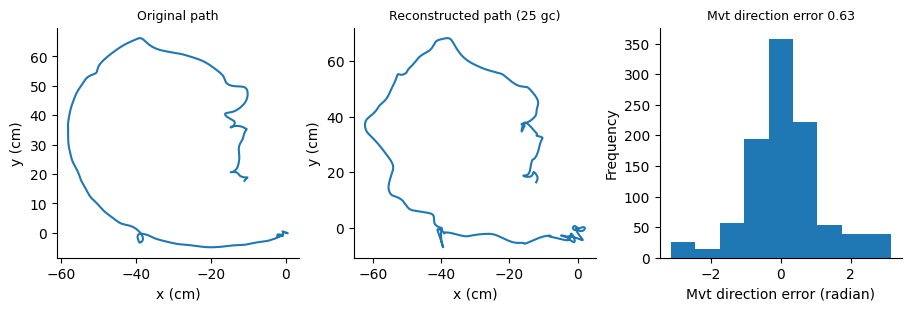

In [58]:
rowSize,colSize= 3,3
ncols=3
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)
start=5000
end=6000 # 1000 samples is 10 seconds

ax = fig.add_subplot(mainSpec[0])
ax.plot(np.cumsum(mvt[start:end,0]),np.cumsum(mvt[start:end,1]))
ax.set_title("Original path",fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")

ax = fig.add_subplot(mainSpec[1])
ax.plot(np.cumsum(predMvt[start:end,0]),np.cumsum(predMvt[start:end,1]))
ax.set_title("Reconstructed path ({} gc)".format(config["n_cells"]),fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")


mvtDir = np.arctan2(mvt[start:end,1],mvt[start:end,0])
predMvtDir = np.arctan2(predMvt[start:end,1],predMvt[start:end,0])
mvtDirError = np.arctan2(np.cos(mvtDir)*np.sin(predMvtDir)-np.sin(mvtDir)*np.cos(predMvtDir),np.cos(mvtDir)*np.cos(predMvtDir)+np.sin(mvtDir)*np.sin(predMvtDir))

ax = fig.add_subplot(mainSpec[2])
ax.hist(mvtDirError,bins=np.linspace(-np.pi,np.pi,10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Mvt direction error (radian)")
ax.set_ylabel("Frequency")
ax.set_title(f"Mvt direction error {np.round(vl_mvt_direction_error(mvtDirError),3)}",fontsize=9)

In [59]:
def calculate_MVL_based_on_df(inputDf):
    mvtDir = np.arctan2(inputDf.y.values,inputDf.x.values)
    predMvtDir = np.arctan2(inputDf.py.values,inputDf.px.values)
    mvtDirError = np.arctan2(np.cos(mvtDir)*np.sin(predMvtDir)-np.sin(mvtDir)*np.cos(predMvtDir),np.cos(mvtDir)*np.cos(predMvtDir)+np.sin(mvtDir)*np.sin(predMvtDir))

    mvtDirError = mvtDirError[~np.isnan(mvtDirError)]

    return np.round(vl_mvt_direction_error(mvtDirError),3)


# Generate a loop to simulate 10 times

In [60]:
import gc

def generateTrainingFileFromSeed(seed):
    np.random.seed(seed)

    grid_param = {}
    grid_param["n_cells"] = 25
    grid_param["orientation"] = np.array([0, np.pi / 3, np.pi / 3 * 2])
    grid_spacing = 35
    grid_param["period"] = np.array(
        [
            grid_spacing * np.cos(np.pi / 6),
            grid_spacing * np.cos(np.pi / 6),
            grid_spacing * np.cos(np.pi / 6),
        ]
    )
    grid_param["offset"] = (
        np.random.rand(grid_param["n_cells"], 2) * grid_param["period"][0]
    )
    peak_rates = np.random.normal(loc=15.0, scale=10.0, size=grid_param["n_cells"])
    peak_rates[peak_rates < 5] = 5
    grid_param["peak_rate"] = peak_rates
    randomHd = np.random.randint(0, 361, size=grid_param["n_cells"])
    grid_param["hd_dir"] = randomHd

    return grid_param


def generate_train_test_dataset(randomSeed,root_fn=ROOT_FN):
    grid_param = generateTrainingFileFromSeed(randomSeed)

    conjunctive_hd_neuron_list = [
        Simulated_conjunctive_grid_cell(
            name=f"{i}",
            offset=grid_param["offset"][i, :],
            orientation=grid_param["orientation"],
            period=grid_param["period"],
            peak_rate=grid_param["peak_rate"][i],
            ap=ap,
            peakAngle=grid_param["hd_dir"][i],
            sharpness=5,
            peakRate=20,
            proportionOfGrid=0.02,
        )
        for i in tqdm(range(grid_param["n_cells"]))
    ]

    test_conjunctive_hd_neuron_list = [
        Simulated_conjunctive_grid_cell(
            name=f"{i}",
            offset=grid_param["offset"][i, :],
            orientation=grid_param["orientation"],
            period=grid_param["period"],
            peak_rate=grid_param["peak_rate"][i],
            ap=lap,
            peakAngle=grid_param["hd_dir"][i],
            sharpness=5,
            peakRate=20,
            proportionOfGrid=0.02,
        )
        for i in tqdm(range(grid_param["n_cells"]))
    ]

    conjunctive_grid_neuron_list = [
        Simulated_conjunctive_grid_cell(
            name=f"{i}",
            offset=grid_param["offset"][i, :],
            orientation=grid_param["orientation"],
            period=grid_param["period"],
            peak_rate=grid_param["peak_rate"][i],
            ap=ap,
            peakAngle=grid_param["hd_dir"][i],
            sharpness=1,
            peakRate=20,
            proportionOfGrid=0.5,
        )
        for i in tqdm(range(grid_param["n_cells"]))
    ]

    test_conjunctive_grid_neuron_list = [
        Simulated_conjunctive_grid_cell(
            name=f"{i}",
            offset=grid_param["offset"][i, :],
            orientation=grid_param["orientation"],
            period=grid_param["period"],
            peak_rate=grid_param["peak_rate"][i],
            ap=lap,
            peakAngle=grid_param["hd_dir"][i],
            sharpness=1,
            peakRate=20,
            proportionOfGrid=0.5,
        )
        for i in tqdm(range(grid_param["n_cells"]))
    ]

    # Save the data generated
    # Generate the training data for conjunctive cells
    con_ifr, con_time, con_pose = generate_data_from_neuron_list(
        conjunctive_hd_neuron_list, ap
    )

    # Generate the test data for conjunctive cells
    con_ifr_test, con_time_test, con_pose_test = generate_data_from_neuron_list(
        test_conjunctive_hd_neuron_list, lap
    )
    
    # Generate the training data for grid cells
    gri_ifr, gri_time, gri_pose = generate_data_from_neuron_list(conjunctive_grid_neuron_list,ap)
    
    # Generate the test data for grid cells
    gri_ifr_test, gri_time_test, gri_pose_test = generate_data_from_neuron_list(test_conjunctive_grid_neuron_list,lap)
    
    # Save the firing rate files

    fn = root_fn + "train_ifr_conjunctive.pkl"
    pickle.dump((con_ifr,con_time),open(fn,"wb"))

    fn = root_fn + "test_ifr_conjunctive.pkl"
    pickle.dump((con_ifr_test,con_time_test),open(fn,"wb"))

    fn = root_fn + "train_ifr_grid.pkl"
    pickle.dump((gri_ifr,gri_time),open(fn,"wb"))

    fn = root_fn + "test_ifr_grid.pkl"
    pickle.dump((gri_ifr_test,gri_time_test),open(fn,"wb"))

    print('Ifr, time saved')
    
    # Save the animal pose files
    assert np.all(con_pose == gri_pose)
    assert np.all(con_pose_test == gri_pose_test)

    fn = root_fn + "train_pose.pkl"
    pickle.dump(con_pose,open(fn,"wb"))

    fn = root_fn + "test_pose.pkl"
    pickle.dump(gri_pose_test,open(fn,"wb"))

    print('Pose saved')
    
    # Save grid params
    fn = root_fn + "grid_params.pkl"
    pickle.dump(grid_param,open(fn,"wb"))

    print('Saved grid params to:',fn)
    
    del conjunctive_hd_neuron_list
    del test_conjunctive_hd_neuron_list
    del conjunctive_grid_neuron_list
    del test_conjunctive_grid_neuron_list
    
    gc.collect()

In [61]:
from scipy.ndimage import gaussian_filter1d

def vl_mvt_direction_error(mvtDirError):
    """
    Calculate the mean direction of the mvt direction error
    """
    xMean = np.nanmean(np.cos(mvtDirError))
    yMean = np.nanmean(np.sin(mvtDirError)) 
    return np.sqrt(xMean*xMean+yMean*yMean)

# HYPERPARAMETERS
config = {"seq_length":20,
            "n_cells":25,
            "hidden_size" :256,
            "num_layers" : 2,
            "num_outputs" : 4, # sin and cos of v0 and v1
            "learning_rate" : 0.02,
            "batch_size" :64,
            "num_epochs": 50}
    
def calculate_MVL_based_on_df(inputDf):
    mvtDir = np.arctan2(inputDf.y.values,inputDf.x.values)
    predMvtDir = np.arctan2(inputDf.py.values,inputDf.px.values)
    mvtDirError = np.arctan2(np.cos(mvtDir)*np.sin(predMvtDir)-np.sin(mvtDir)*np.cos(predMvtDir),np.cos(mvtDir)*np.cos(predMvtDir)+np.sin(mvtDir)*np.sin(predMvtDir))

    mvtDirError = mvtDirError[~np.isnan(mvtDirError)]

    return np.round(vl_mvt_direction_error(mvtDirError),3)

def train_model(cellType='grid',root_fn=ROOT_FN):
    train_ifr,train_pose, train_grid_coord, test_ifr, test_pose, test_grid_coord, grid_param, train_time, test_time = load_position_ifr_dataset_conjunctive_simulation(cellType=cellType)
    df, model,best_model_state = train_lstm(config,
                                    train_grid_coord,train_time,train_ifr,
                                    test_grid_coord,test_time, test_ifr)
    
    modelFn = os.path.join(root_fn,'model_states','grid_cell_model.pt')
    os.makedirs(os.path.dirname(modelFn), exist_ok=True)
    print("saving the model state_dict to",modelFn)
    torch.save(best_model_state, modelFn)
    

    
def test_model(cellType='grid',root_fn=ROOT_FN):
    train_ifr,train_pose, train_grid_coord, test_ifr, test_pose, test_grid_coord, grid_param, train_time, test_time = load_position_ifr_dataset_conjunctive_simulation(cellType=cellType)

    
    train_dataset = NeuralDatasetSimple(ifr =train_ifr[:,:config["n_cells"]], pose=train_grid_coord[:,0:4], time=train_time,  seq_length=config["seq_length"])
    ifr_normalization_means = train_dataset.ifr_normalization_means
    ifr_normalization_stds = train_dataset.ifr_normalization_stds

    test_dataset = NeuralDatasetSimple(ifr =test_ifr[:,:config["n_cells"]], 
                                pose=test_grid_coord[:,:config["num_outputs"]], 
                                time = test_time,
                                seq_length=config["seq_length"],
                                ifr_normalization_means=ifr_normalization_means,
                                ifr_normalization_stds=ifr_normalization_stds)

    test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=config["batch_size"] , 
                                                        num_workers=2, shuffle=False, pin_memory=False) # to load batches
    
    device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('mps'))
    #print("Device available:", device)
    model = LSTMSimple(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)
    modelFn = os.path.join(root_fn,'model_states','grid_cell_model.pt')
    model.load_state_dict(torch.load(modelFn))
    
    len(test_dataset)
    predictions = np.empty((len(test_dataset),4))
    loadedLabels = np.empty((len(test_dataset),4))
    timeHolder = np.empty((len(test_dataset),1))
    predictions.shape, loadedLabels.shape
    
    i = 0
    poseHolder = []
    model.eval()
    with torch.no_grad():
        for imgs, labels, time in test_data_loader: 
            imgs = imgs.to(device=device)
            outputs = model(imgs)
            outputs = outputs.to(device)
            loadedLabels[i:(i+labels.shape[0]),:] = labels
            predictions[i:(i+labels.shape[0]),:] = outputs.cpu().numpy()
            timeHolder[i:(i+labels.shape[0]),:] = time

            i=i+labels.shape[0]
            
    
    # Smooth the model predictions
    predictions = gaussian_filter1d(predictions,sigma = 5,mode="nearest" ,axis=0)
    loadedLabels = gaussian_filter1d(loadedLabels,sigma = 5,mode="nearest" ,axis=0)
    
    predMvt = gridSpaceToMovementPath(predictions,grid_period=grid_param["period"],orientation=grid_param["orientation"])
    mvt = gridSpaceToMovementPath(loadedLabels,grid_period=grid_param["period"],orientation=grid_param["orientation"])
    
    positionSamplingRate=1/50

    speed = np.sqrt(np.sum(mvt**2,axis=1))/positionSamplingRate
    
    resultDf = pd.DataFrame({
    'x': mvt[:, 0],
    'y': mvt[:, 1],
    'px': predMvt[:, 0],
    'py': predMvt[:, 1],
    'speed': speed
    })
    
    outputMVL = calculate_MVL_based_on_df(resultDf)
    
    return outputMVL, resultDf
        

In [64]:
testingH = []
condH = []
mvlH = []
# Run the loop 10 times
for i in range(10):
    rowResultFn = f'{ROOT_FN}/mvl_results_test_{i}.csv'
    
    if os.path.exists(rowResultFn):
        print("Skipping",i)
        continue
    
    #Start generating files
    testingH.append(i)
    testingH.append(i)
    #Generate a file for training
    generate_train_test_dataset(i)
    
    #Train and test the model for low hd-selectivty grid cells
    train_model(cellType='grid')
    print('Testing Model on low hd-selectivity grid cells')
    outputMvlG, gridResDf = test_model(cellType='grid')
    condH.append('grid')
    mvlH.append(outputMvlG)
    gridResDf.to_csv(f'{{ROOT_FN}}/grid_training_result.csv')
    
    #Train and test the model for high hd-selectivty grid cells
    train_model(cellType='conjunctive')
    print('Testing Model on high hd-selectivity grid cells')
    outputMvlC,conjResDf = test_model(cellType='conjunctive')
    condH.append('conjunctive')
    mvlH.append(outputMvlC)
    conjResDf.to_csv(f'{ROOT_FN}/conj_training_result.csv')
    
    rowDf = pd.DataFrame({'testing':[i,i],'condition':['grid','conjunctive'],'mvl':[outputMvlG,outputMvlC]})
    rowDf.to_csv(rowResultFn)
    print("Dataframe Saved for run:",i)
    


Skipping 0
Skipping 1
Skipping 2
Skipping 3
Skipping 4
Skipping 5
Skipping 6
Skipping 7
Skipping 8
Skipping 9
